In [3]:

import pandas as pd
import numpy as np
from datetime import date as datetime_date, timedelta
import holidays
import warnings
warnings.filterwarnings("ignore")
from pymongo import MongoClient
from calendar import monthrange
from sklearn.preprocessing import LabelEncoder
import requests
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(10,4)
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split , TimeSeriesSplit
pd.set_option('display.max_columns', 500)
import numpy as np

In [4]:
client = MongoClient("mongodb://localhost:27017")
db = client["pvvnl"]
collection1 = db['sensor_data']
collection2 = db['train_data']
collection3 = db['test_data']


# db.list_collection_names()

In [11]:
print(collection1.name)
print("count at starting",collection1.count_documents({}))
collection1.drop()
print("count at ending",collection1.count_documents({}))


sensor_data
count at starting 20
count at ending 0


In [5]:
def holidays_list(start_date, end_date):
    try:
        holiday_list = []

        def is_holiday(single_date):
            year = single_date.year
            country_holidays = holidays.CountryHoliday('India', years=year)
            return single_date in country_holidays or single_date.weekday() == 6  # Sunday is represented by 6

        date_list = [
            (single_date, holidays.CountryHoliday('India', years=single_date.year).get(single_date))
            for single_date in (start_date + timedelta(n) for n in range((end_date - start_date).days + 1))
            if is_holiday(single_date)]
        for date, name in date_list:
            # print(f"{date}: {name}")
            holiday_list.append(date)
        return holiday_list
    except Exception as e:
        print(e)
start_date = datetime_date(2022, 11, 18)
end_date = datetime_date(2023, 11, 18)
h_l = holidays_list(start_date, end_date)

In [138]:
def create_features(hourly_data):
    hourly_data = hourly_data.copy()

    # Check if the index is in datetime format
    if not isinstance(hourly_data.index, pd.DatetimeIndex):
        hourly_data.index = pd.to_datetime(hourly_data.index)

    hourly_data['day'] = hourly_data.index.day
    hourly_data['hour'] = hourly_data.index.hour
    hourly_data['month'] = hourly_data.index.month
    hourly_data['dayofweek'] = hourly_data.index.dayofweek
    hourly_data['quarter'] = hourly_data.index.quarter
    hourly_data['dayofyear'] = hourly_data.index.dayofyear
    hourly_data['weekofyear'] = hourly_data.index.isocalendar().week
    hourly_data['year'] = hourly_data.index.year
    return hourly_data


def add_lags(df):
    # print(df)
    target_map = df['Kwh'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 hour')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('12 hours')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('24 hours')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag5'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag6'] = (df.index - pd.Timedelta('90 days')).map(target_map)



    return df


In [2]:
sensor_df  = pd.read_parquet("d:/Load_forecasting2/MyLoadForcasting/artifacts/data_ingestion/data.parquet")
dframe = sensor_df.groupby('sensor')

# holidays data
start_date = datetime_date(2022, 11, 18)
end_date = datetime_date(2023, 11, 18)
holiday_lst = holidays_list(start_date, end_date)
# holiday_lst = holidays_list()

#weather data
weather_data = pd.read_csv(r"D:\Load_forecasting2\MyLoadForcasting\weather.csv")
weather_data['Clock'] = pd.to_datetime(weather_data['Clock'])
weather_data.set_index(['Clock'],inplace=True, drop=True)
weather_data.drop(['temp'],axis=1,inplace=True)
weather_data.drop(['precipitation','apparent_temp'],axis=1,inplace=True)
# weather_data = data_from_weather_api()

for labeled_id, data in dframe:
    sensor_df = data

    """ Data Validation regarding Voltage and Current """
    filtered_df = sensor_df[((sensor_df['R_Voltage'] == 0) | (sensor_df['Y_Voltage'] == 0) | (sensor_df['B_Voltage'] == 0)) & (
                (sensor_df['R_Current'] == 0) | (
                sensor_df['Y_Current'] == 0) | (sensor_df['B_Current'] == 0))]
    filtered_df['Kwh'] = 0
    sensor_df.loc[sensor_df.index.isin(filtered_df.index), :] = filtered_df

    '''Data Conversion'''
    sensor_df['Clock'] = pd.to_datetime(sensor_df['Clock'])
    sensor_df.set_index(['Clock'], inplace=True, drop=True)
    sensor_df = sensor_df[sensor_df.index >= '2022-11-18 00:00:00']
    # sensor_id = sensor_df['sensor'].unique()
    '''Resampling dataframe into one-hour interval '''

    dfresample = sensor_df[['Kwh']].resample(rule='1H').sum()
    # dfresample.dropna(subset=['Kwh'], inplace=True)
    # dfresample.fillna(value= 0 , inplace=True)
    dfresample['sensor_id'] = labeled_id
    # dfresample.reset_index(['Clock'], inplace=True, drop=True)

    dfresample=pd.merge(dfresample,weather_data, on="Clock")
    dfresample['holiday'] = np.isin(dfresample.index.date, holiday_lst).astype(int)
    print(labeled_id,dfresample.isna().sum().sum())
    dfresample = add_lags(dfresample)
    dfresample = create_features(dfresample)
    dfresample.reset_index(['Clock'],inplace=True)
    # dfresample['holiday'] = dfresample['Clock'].dt.date.isin(holiday_lst).astype(int)
    # dfresample['holiday'] = dfresample.index.dt.date.isin(holiday_lst).astype(int)    
    # dfresample['holiday'] = dfresample.index.date.isin(holiday_lst).astype(int)


print(len(holiday_lst))



NameError: name 'pd' is not defined

In [94]:
dfresample[dfresample['holiday']==1]

,Clock,Kwh,sensor_id,humidity,rain,cloud_cover,wind_speed,temp_diff,holiday,lag1,lag2,lag3,lag4,lag5,lag6,day,hour,month,dayofweek,quarter,dayofyear,weekofyear,year
120,2022-12-25 00:00:00,561100.0,63ca403ccd66f3.47133508,95,0.0,0,12.5,-0.3,1,NaN,NaN,NaN,704100.0,935600.0,506100.0,25,0,12,6,4,359,51,2022
121,2022-12-25 01:00:00,425900.0,63ca403ccd66f3.47133508,96,0.0,0,13.0,-0.3,1,NaN,NaN,NaN,561100.0,880600.0,411800.0,25,1,12,6,4,359,51,2022
122,2022-12-25 02:00:00,363700.0,63ca403ccd66f3.47133508,97,0.0,0,12.0,-0.3,1,NaN,NaN,NaN,425900.0,765100.0,363700.0,25,2,12,6,4,359,51,2022
123,2022-12-25 03:00:00,332400.0,63ca403ccd66f3.47133508,98,0.0,0,11.2,-0.4,1,NaN,NaN,NaN,363700.0,678500.0,341700.0,25,3,12,6,4,359,51,2022
124,2022-12-25 04:00:00,325100.0,63ca403ccd66f3.47133508,99,0.0,0,10.4,-0.3,1,NaN,NaN,NaN,332400.0,602300.0,347000.0,25,4,12,6,4,359,51,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7867,2023-11-12 19:00:00,836100.0,63ca403ccd66f3.47133508,74,0.0,0,6.5,-1.3,1,1038400.0,1166900.0,1181500.0,800700.0,470500.0,764300.0,12,19,11,6,4,316,45,2023
7868,2023-11-12 20:00:00,784900.0,63ca403ccd66f3.47133508,79,0.0,0,6.4,-1.2,1,1076800.0,1340500.0,1312500.0,836100.0,625700.0,697700.0,12,20,11,6,4,316,45,2023
7869,2023-11-12 21:00:00,740700.0,63ca403ccd66f3.47133508,81,0.0,0,6.4,-0.6,1,1096400.0,1509400.0,1485200.0,784900.0,741600.0,688100.0,12,21,11,6,4,316,45,2023
7870,2023-11-12 22:00:00,691500.0,63ca403ccd66f3.47133508,83,0.0,0,7.0,-0.5,1,1125600.0,1716300.0,1685200.0,740700.0,814300.0,675500.0,12,22,11,6,4,316,45,2023


In [95]:
dfresample

,Clock,Kwh,sensor_id,humidity,rain,cloud_cover,wind_speed,temp_diff,holiday,lag1,lag2,lag3,lag4,lag5,lag6,day,hour,month,dayofweek,quarter,dayofyear,weekofyear,year
0,2022-12-20 00:00:00,182200.0,63ca403ccd66f3.47133508,91,0.0,15,7.7,-0.5,0,NaN,NaN,NaN,NaN,NaN,NaN,20,0,12,1,4,354,51,2022
1,2022-12-20 01:00:00,321500.0,63ca403ccd66f3.47133508,91,0.0,6,7.5,-0.4,0,NaN,NaN,NaN,182200.0,NaN,NaN,20,1,12,1,4,354,51,2022
2,2022-12-20 02:00:00,289100.0,63ca403ccd66f3.47133508,92,0.0,8,7.8,-0.2,0,NaN,NaN,NaN,321500.0,NaN,NaN,20,2,12,1,4,354,51,2022
3,2022-12-20 03:00:00,275800.0,63ca403ccd66f3.47133508,93,0.0,3,8.3,-0.2,0,NaN,NaN,NaN,289100.0,NaN,NaN,20,3,12,1,4,354,51,2022
4,2022-12-20 04:00:00,278600.0,63ca403ccd66f3.47133508,94,0.0,0,7.6,-0.3,0,NaN,NaN,NaN,275800.0,NaN,NaN,20,4,12,1,4,354,51,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8011,2023-11-18 19:00:00,699300.0,63ca403ccd66f3.47133508,55,0.0,0,4.2,1.8,0,767700.0,1181600.0,1345800.0,669400.0,577000.0,686300.0,18,19,11,5,4,322,46,2023
8012,2023-11-18 20:00:00,709100.0,63ca403ccd66f3.47133508,57,0.0,0,1.1,-0.5,0,845800.0,1256100.0,1520100.0,699300.0,667700.0,642500.0,18,20,11,5,4,322,46,2023
8013,2023-11-18 21:00:00,706300.0,63ca403ccd66f3.47133508,72,0.0,0,5.6,-3.9,0,820400.0,1392600.0,1872700.0,709100.0,728900.0,677400.0,18,21,11,5,4,322,46,2023
8014,2023-11-18 22:00:00,672100.0,63ca403ccd66f3.47133508,76,0.0,0,6.4,-0.6,0,776200.0,1710200.0,2116500.0,706300.0,789400.0,654400.0,18,22,11,5,4,322,46,2023


In [112]:
df= dfresample.fillna(value=0)
dfresample.columns

Index(['Clock', 'Kwh', 'sensor_id', 'humidity', 'rain', 'cloud_cover',
       'wind_speed', 'temp_diff', 'holiday', 'lag1', 'lag2', 'lag3', 'lag4',
       'lag5', 'lag6', 'day', 'hour', 'month', 'dayofweek', 'quarter',
       'dayofyear', 'weekofyear', 'year'],
      dtype='object')

In [110]:
df.drop(['Clock','sensor_id','lag1', 'lag2', 'lag3', 'lag4',
       'lag5', 'lag6', 'day', 'hour', 'month', 'dayofweek', 'quarter',
       'dayofyear', 'weekofyear', 'year'],axis=1, inplace=True)

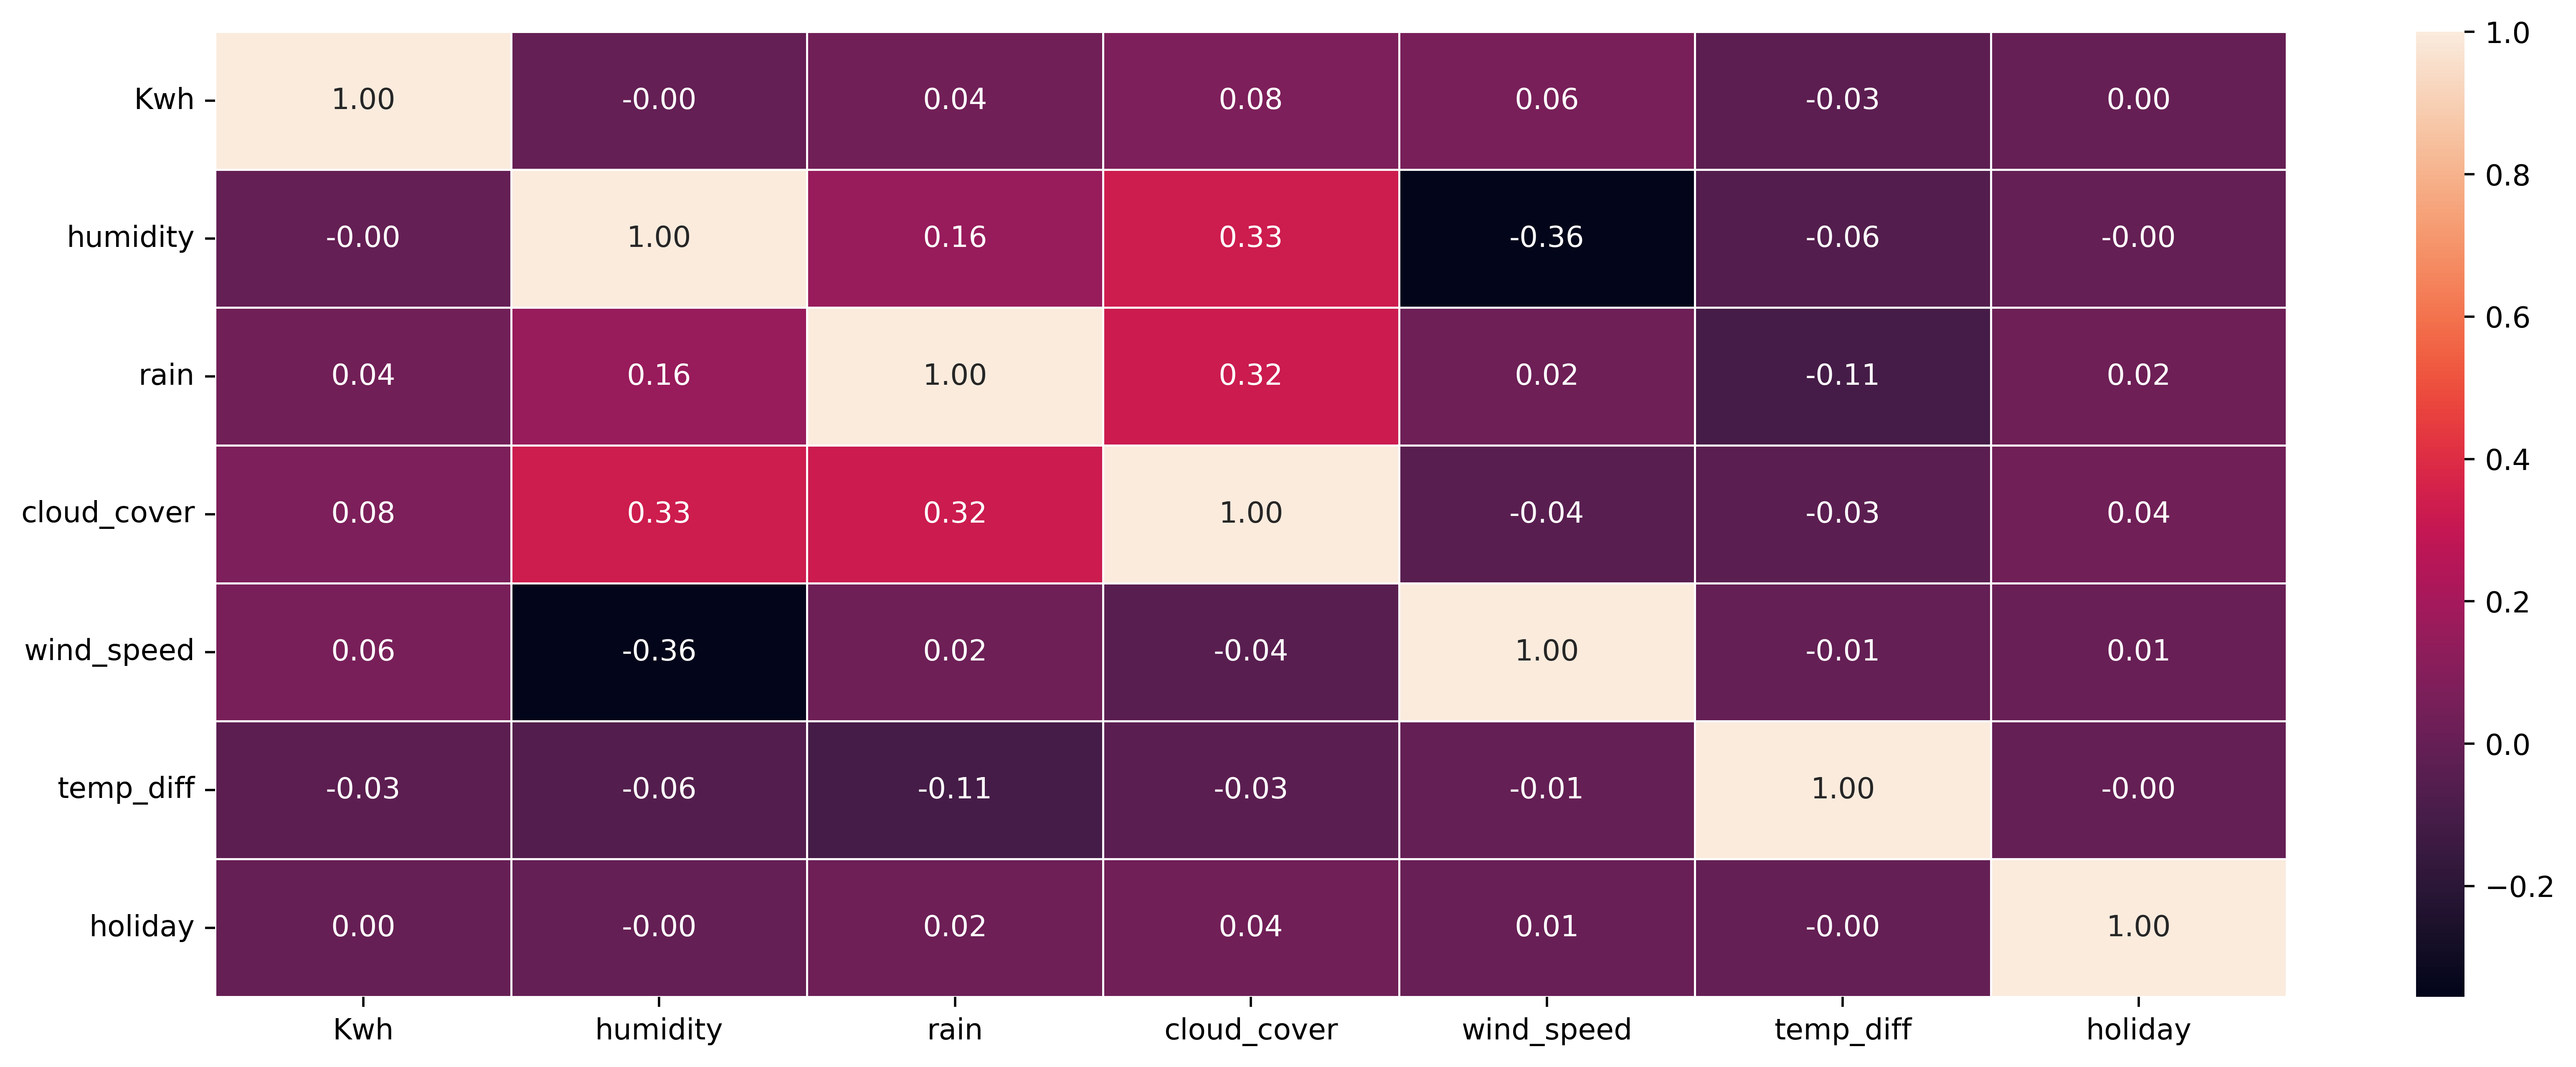

In [111]:
# correlation
corr = df.corr(method = 'pearson')
corr
plt.figure(figsize=(16,6), dpi =500)
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [118]:
dfresample.set_index(['Clock'],inplace=True, drop=True)
df1 = dfresample[['Kwh']]

In [120]:
df2= df1

In [144]:
future = pd.date_range(start='2023-11-19',end='2023-12-31', freq='1H')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df1['isFuture'] = False
df_and_future = pd.concat([df1, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)
df_and_future['sensor'] = 1

future_w_features = df_and_future.query('isFuture').copy()

In [140]:
future_df

,isFuture
2023-11-19 00:00:00,True
2023-11-19 01:00:00,True
2023-11-19 02:00:00,True
2023-11-19 03:00:00,True
2023-11-19 04:00:00,True
...,...
2023-12-30 20:00:00,True
2023-12-30 21:00:00,True
2023-12-30 22:00:00,True
2023-12-30 23:00:00,True


In [141]:
df1

,Kwh,isFuture
Clock,,
2022-12-20 00:00:00,182200.0,False
2022-12-20 01:00:00,321500.0,False
2022-12-20 02:00:00,289100.0,False
2022-12-20 03:00:00,275800.0,False
2022-12-20 04:00:00,278600.0,False
...,...,...
2023-11-18 19:00:00,699300.0,False
2023-11-18 20:00:00,709100.0,False
2023-11-18 21:00:00,706300.0,False


In [142]:
df_and_future

,Kwh,isFuture,day,hour,month,dayofweek,quarter,dayofyear,weekofyear,year,lag1,lag2,lag3,lag4,lag5,lag6,sensor
2022-12-20 00:00:00,182200.0,False,20,0,12,1,4,354,51,2022,NaN,NaN,NaN,NaN,NaN,NaN,1
2022-12-20 01:00:00,321500.0,False,20,1,12,1,4,354,51,2022,182200.0,NaN,NaN,NaN,NaN,NaN,1
2022-12-20 02:00:00,289100.0,False,20,2,12,1,4,354,51,2022,321500.0,NaN,NaN,NaN,NaN,NaN,1
2022-12-20 03:00:00,275800.0,False,20,3,12,1,4,354,51,2022,289100.0,NaN,NaN,NaN,NaN,NaN,1
2022-12-20 04:00:00,278600.0,False,20,4,12,1,4,354,51,2022,275800.0,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 20:00:00,NaN,True,30,20,12,5,4,364,52,2023,NaN,NaN,NaN,NaN,795000.0,1013200.0,1
2023-12-30 21:00:00,NaN,True,30,21,12,5,4,364,52,2023,NaN,NaN,NaN,NaN,819200.0,1021800.0,1
2023-12-30 22:00:00,NaN,True,30,22,12,5,4,364,52,2023,NaN,NaN,NaN,NaN,773600.0,1115100.0,1
2023-12-30 23:00:00,NaN,True,30,23,12,5,4,364,52,2023,NaN,NaN,NaN,NaN,731100.0,1254700.0,1


In [1]:
future_w_features.head(60)

NameError: name 'future_w_features' is not defined

In [143]:
df_and_future.isna().sum()

Kwh           1009
isFuture         0
day              0
hour             0
month            0
dayofweek        0
quarter          0
dayofyear        0
weekofyear       0
year             0
lag1          1009
lag2          1009
lag3          1009
lag4          1009
lag5          1440
lag6          2160
sensor           0
dtype: int64